In [1]:
%run ../../main.py
%run ./CAR_creation.ipynb

In [2]:
import pyarc.qcba as qcba
import pyarc.utils.plotting as plotils

In [3]:
from pyarc.qcba.data_structures import *

quant_rules = [ QuantitativeCAR(r) for r in rules ]
rules

[CAR {a-list-celebrities=<0;2)} => {class=box-office-bomb} sup: 0.31 conf: 1.00 len: 2, id: 42,
 CAR {estimated-budget=<250;300)} => {class=main-stream-hit} sup: 0.06 conf: 1.00 len: 2, id: 4,
 CAR {estimated-budget=<0;50),a-list-celebrities=<4;6)} => {class=critical-success} sup: 0.06 conf: 1.00 len: 3, id: 24,
 CAR {a-list-celebrities=<6;8)} => {class=critical-success} sup: 0.03 conf: 1.00 len: 2, id: 1,
 CAR {estimated-budget=<100;150),a-list-celebrities=<4;6)} => {class=main-stream-hit} sup: 0.03 conf: 1.00 len: 3, id: 10,
 CAR {estimated-budget=<150;200),a-list-celebrities=<4;6)} => {class=main-stream-hit} sup: 0.03 conf: 1.00 len: 3, id: 16,
 CAR {estimated-budget=<200;250)} => {class=box-office-bomb} sup: 0.06 conf: 0.67 len: 2, id: 9,
 CAR {estimated-budget=<0;50)} => {class=box-office-bomb} sup: 0.14 conf: 0.62 len: 2, id: 29,
 CAR {a-list-celebrities=<4;6)} => {class=main-stream-hit} sup: 0.11 conf: 0.50 len: 2, id: 33]

In [4]:
ds = movies_train_undiscr.reset_index()
quant_dataset = QuantitativeDataFrame(ds)

quant_dataset.dataframe.head()

,estimated-budget,a-list-celebrities,class
0,160,1,box-office-bomb
1,55,2,box-office-bomb
2,78,1,box-office-bomb
3,66,3,box-office-bomb
4,223,2,box-office-bomb


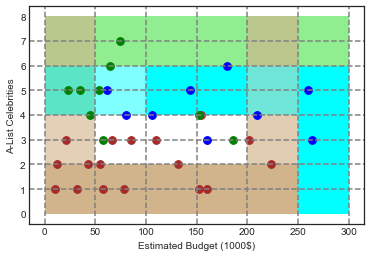

In [5]:
utils.plot_quant_rules(quant_rules)

In [6]:
from pyarc.qcba.transformation import *


qcba_transformation = QCBATransformation(quant_dataset)

In [7]:
quant_dataset.dataframe["estimated-budget"]#.column("estimated-budget")
quant_dataset._QuantitativeDataFrame__preprocessed_columns


{'a-list-celebrities': array([1, 2, 3, 4, 5, 6, 7]),
 'class': array(['box-office-bomb', 'critical-success', 'main-stream-hit'], 
       dtype='<U16'),
 'estimated-budget': array([ 10,  12,  21,  23,  32,  35,  43,  45,  54,  55,  58,  62,  65,
         66,  74,  78,  80,  85, 106, 110, 132, 143, 152, 154, 160, 180,
        186, 202, 209, 223, 260, 264])}

In [8]:
transformed_rules, def_class = qcba_transformation.transform(quant_rules)

# Full qCBA transformation

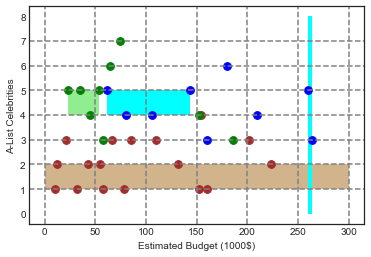

In [9]:
plotils.plot_quant_rules(transformed_rules)

# Step by step transformation

## Refitting

In [10]:
refitted_rules = qcba_transformation.refitter.transform(quant_rules)

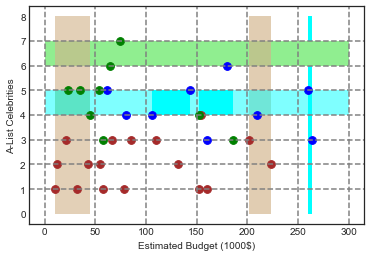

In [11]:
plotils.plot_quant_rules(refitted_rules)

## Literal pruning

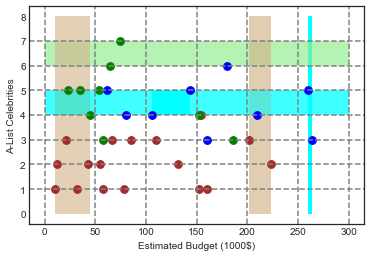

In [12]:
literal_pruned_rules = qcba_transformation.literal_pruner.transform(refitted_rules)

plotils.plot_quant_rules(literal_pruned_rules)

## Trimming

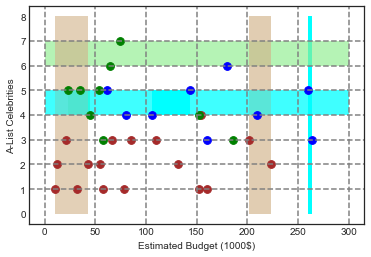

In [13]:
trimmed_rules = qcba_transformation.trimmer.transform(literal_pruned_rules)

plotils.plot_quant_rules(trimmed_rules)

## Extension

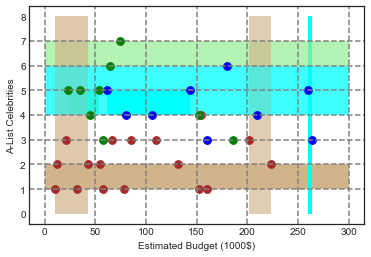

In [14]:
extended_rules = qcba_transformation.extender.transform(trimmed_rules)

plotils.plot_quant_rules(extended_rules)

In [15]:
extended_rules

[CAR {a-list-celebrities=<1;2>} => {class=box-office-bomb} sup: 0.31 conf: 1.00 len: 2, id: 42,
 CAR {estimated-budget=<260;264>} => {class=main-stream-hit} sup: 0.06 conf: 1.00 len: 2, id: 4,
 CAR {a-list-celebrities=<4;5>,estimated-budget=<23;54>} => {class=critical-success} sup: 0.11 conf: 1.00 len: 3, id: 24,
 CAR {a-list-celebrities=<6;7>} => {class=critical-success} sup: 0.09 conf: 0.67 len: 2, id: 1,
 CAR {a-list-celebrities=<4;5>,estimated-budget=<62;143>} => {class=main-stream-hit} sup: 0.11 conf: 1.00 len: 3, id: 10,
 CAR {a-list-celebrities=<4;6>} => {class=main-stream-hit} sup: 0.40 conf: 0.50 len: 2, id: 16,
 CAR {estimated-budget=<202;223>} => {class=box-office-bomb} sup: 0.09 conf: 0.67 len: 2, id: 9,
 CAR {estimated-budget=<10;43>} => {class=box-office-bomb} sup: 0.20 conf: 0.71 len: 2, id: 29,
 CAR {a-list-celebrities=<4;6>} => {class=main-stream-hit} sup: 0.40 conf: 0.50 len: 2, id: 33]

## Postpruning

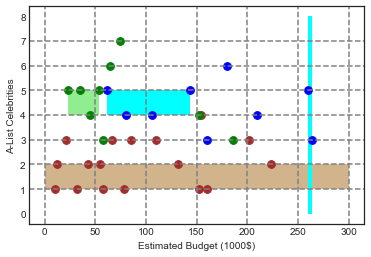

In [16]:
pruned_rules, default_class = qcba_transformation.post_pruner.transform(extended_rules)

plotils.plot_quant_rules(pruned_rules)

In [17]:
pruned_rules

[CAR {a-list-celebrities=<1;2>} => {class=box-office-bomb} sup: 0.31 conf: 1.00 len: 2, id: 42,
 CAR {a-list-celebrities=<4;5>,estimated-budget=<62;143>} => {class=main-stream-hit} sup: 0.11 conf: 1.00 len: 3, id: 10,
 CAR {a-list-celebrities=<4;5>,estimated-budget=<23;54>} => {class=critical-success} sup: 0.11 conf: 1.00 len: 3, id: 24,
 CAR {estimated-budget=<260;264>} => {class=main-stream-hit} sup: 0.06 conf: 1.00 len: 2, id: 4]

(35.0, 1.0, 0.4857142857142857)

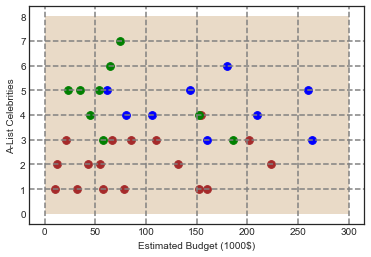

In [18]:
default_rule = extended_rules[0].copy()
default_rule.antecedent = [
    ("a-list-celebrities", Interval(0, 8, True, True)),
    ("estimated-budget", Interval(0, 300, True, True))
]
default_rule.consequent = ("class", default_class)
default_rule.update_properties(quant_dataset)

plotils.plot_quant_rules([default_rule])

default_rule.support, default_rule.confidence
s, c = quant_dataset.calculate_rule_statistics(default_rule)

s * quant_dataset.size, s, c

## Overlap pruning

In [ ]:
transaction_overlap_rules = qcba_transformation.overlap_pruner.transform(pruned_rules, default_class)

plotils.plot_quant_rules(transaction_overlap_rules)

CAR {a-list-celebrities=<1;2>} => {class=box-office-bomb} sup: 0.31 conf: 1.00 len: 2, id: 42
[ True  True  True False  True  True  True False False  True  True False
  True  True False  True False False False False False False False False
 False False False False False False False False False False False]
CAR {a-list-celebrities=<4;5>,estimated-budget=<62;143>} => {class=main-stream-hit} sup: 0.11 conf: 1.00 len: 3, id: 10
any False
CAR {a-list-celebrities=<4;5>,estimated-budget=<23;54>} => {class=critical-success} sup: 0.11 conf: 1.00 len: 3, id: 24
any False
CAR {estimated-budget=<260;264>} => {class=main-stream-hit} sup: 0.06 conf: 1.00 len: 2, id: 4
any False
not including CAR {a-list-celebrities=<4;5>,estimated-budget=<62;143>} => {class=main-stream-hit} sup: 0.11 conf: 1.00 len: 3, id: 10
not including CAR {a-list-celebrities=<4;5>,estimated-budget=<23;54>} => {class=critical-success} sup: 0.11 conf: 1.00 len: 3, id: 24
not including CAR {estimated-budget=<260;264>} => {class=ma

In [20]:
pruned_rules

[CAR {a-list-celebrities=<1;2>} => {class=box-office-bomb} sup: 0.31 conf: 1.00 len: 2, id: 42,
 CAR {a-list-celebrities=<4;5>,estimated-budget=<62;143>} => {class=main-stream-hit} sup: 0.11 conf: 1.00 len: 3, id: 10,
 CAR {a-list-celebrities=<4;5>,estimated-budget=<23;54>} => {class=critical-success} sup: 0.11 conf: 1.00 len: 3, id: 24,
 CAR {estimated-budget=<260;264>} => {class=main-stream-hit} sup: 0.06 conf: 1.00 len: 2, id: 4]

# Single rules demonstration

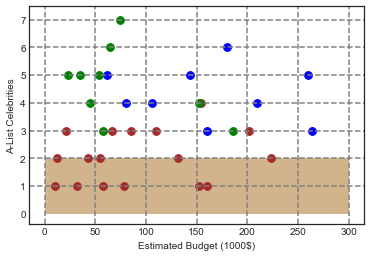

In [21]:
quant_rule1 = quant_rules[0]

plotils.plot_quant_rules([quant_rule1])

## Refitting

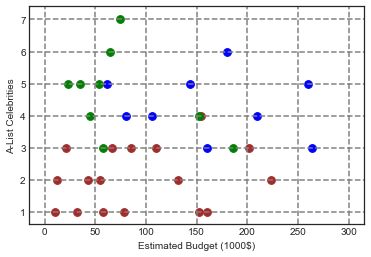

In [22]:
refitted_qrule1 = qcba_transformation.refitter.transform([quant_rule1])

# edit the maxval so that we can see the rule
#refitted_qrule1[0].antecedent[0][1].maxval=1.2

plotils.plot_quant_rules(refitted_qrule1)

## Literal pruning

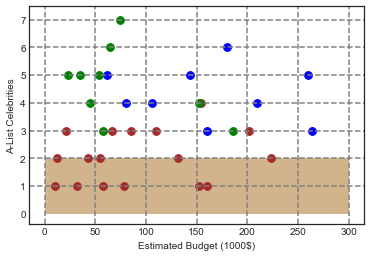

In [23]:
quant_rule1 = quant_rules[0]

plotils.plot_quant_rules([quant_rule1])

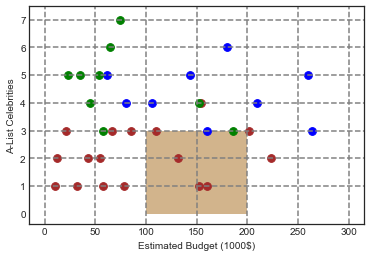

In [22]:
qrule_to_prune = quant_rule1.copy() 

# edit an item in antecedent to decrease confidence
# and see if the item gets pruned during literal pruning
# procedure
qrule_to_prune.antecedent[0] = "a-list-celebrities", Interval(0, 3, True, True)
qrule_to_prune.antecedent.append(("estimated-budget", Interval(100, 200, True, True)))

plotils.plot_quant_rules([qrule_to_prune])

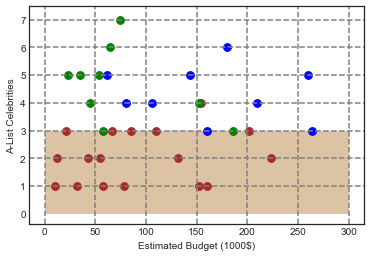

In [23]:
qrule1_literal_pruned = qcba_transformation.literal_pruner.transform([qrule_to_prune])


plotils.plot_quant_rules(qrule1_literal_pruned)

## Trimming

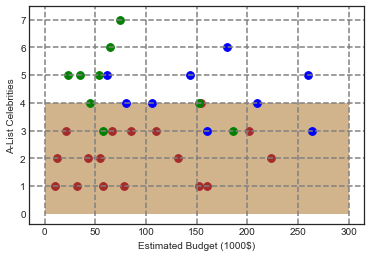

In [24]:
rule_to_trim = quant_rule1

rule_to_trim.antecedent[0] = "a-list-celebrities", Interval(0, 4, True, False)

plotils.plot_quant_rules([rule_to_trim])

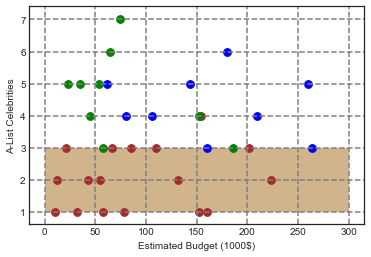

In [25]:
trimmed_rule = qcba_transformation.trimmer.transform([rule_to_trim])


plotils.plot_quant_rules(trimmed_rule)

## Extending

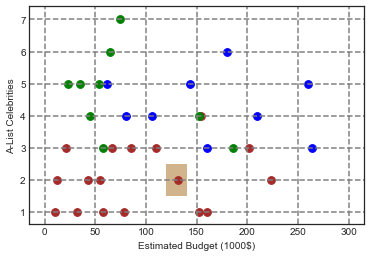

In [26]:
rule_to_extend = quant_rule1.copy()

rule_to_extend.antecedent = [
    ("a-list-celebrities", Interval(1.5, 2.5, True, True)),
    ("estimated-budget", Interval(120, 140, True, True))
]


plotils.plot_quant_rules([rule_to_extend])

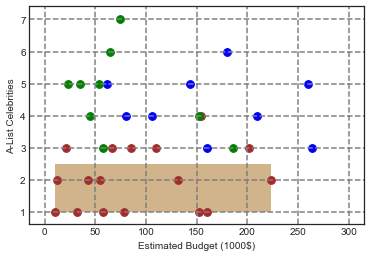

In [27]:
extended_rule = qcba_transformation.extender.transform([rule_to_extend])

plotils.plot_quant_rules(extended_rule)